In [92]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mp_img
import numpy as np
import tifffile
import os
import json
from PIL import Image
from glob import glob
import seaborn as sns

In [46]:
DATA_PATH = Path(r'/data/classes/2024/fall/cs426/roota5351/assignment_4/data')
IMG_PATH = DATA_PATH / 'images'
LABEL_PATH = DATA_PATH / 'mask_single_channel'
PLOT_PATH = Path(r'plots/')

In [94]:
RANDOM_STATE = 12535235
tf.random.set_seed(RANDOM_STATE)

BATCH_SIZE = 8
DATA_COUNT = 324
BUFFER_SIZE = DATA_COUNT

IMG_SIZE = (500, 500)
TARG_IMG_SIZE = (256, 256)
TARG_H, TARG_W = TARG_IMG_SIZE[0], TARG_IMG_SIZE[1]

In [48]:
# create list datasets

fnames = [fname.split('/')[-1] for fname in glob(str(IMG_PATH/'*.png'))]

fname_pairs = sorted([
                [str(IMG_PATH/fname), str(LABEL_PATH/fname)]
                 for fname in fnames
                ])

list_ds = tf.data.Dataset.from_tensor_slices(fname_pairs).shuffle(DATA_COUNT, seed=RANDOM_STATE)

In [95]:
# create splits

test_size = int(DATA_COUNT * 0.3)
val_size = int((DATA_COUNT - test_size) * 0.3)

train_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

train_ds = train_ds.skip(val_size)
val_ds = train_ds.take(val_size)

train_ds.cardinality().numpy(), val_ds.cardinality().numpy(), test_ds.cardinality().numpy()

(159, 68, 97)

In [96]:
# Create function to load in datapoints

def load_img_lbl_pair(fpath_pair):
    img_path, lbl_path = fpath_pair[0], fpath_pair[1]
    img = tf.io.read_file(img_path)
    lbl = tf.io.read_file(lbl_path)
    img, lbl = tf.cast(tf.io.decode_png(img), tf.float32)/255.0, tf.io.decode_png(lbl)
    return img, lbl

# map datasets to this function^
train_ds = train_ds.map(load_img_lbl_pair, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_img_lbl_pair, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_img_lbl_pair, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
# define dicts for labels

int2name = {
    0: "Impervious Surfaces",
    1: "Building",
    2: "Low Vegetation",
    3: "Tree",
    4: "Car",
    5: "Clutter/Background"
}

name2int = {
    "Impervious Surfaces": 0,
    "Building": 1,
    "Low Vegetation": 2,
    "Tree": 3,
    "Car": 4,
    "Clutter/Background": 5,  
}

In [97]:
# define preprocessing and augmentation layers

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, h, w):
        super().__init__()
        self.resize_inputs = keras.layers.Resizing(h, w)
        self.resize_labels = keras.layers.Resizing(h, w, interpolation='nearest')
        
    def call(self, inputs, labels):
        inputs = self.resize_inputs(inputs)
        labels = self.resize_labels(labels)
        return inputs, labels
    
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.randflip_inputs = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
        self.randflip_labels = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.randflip_inputs(inputs)
        labels = self.randflip_labels(labels)
        
        return inputs, labels

In [98]:
# create batches

train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(Preprocess(h=TARG_H, w=TARG_W))
    .map(Augment(seed=RANDOM_STATE))
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_batches = val_ds.batch(BATCH_SIZE).map(Preprocess(h=TARG_H, w=TARG_W))
test_batches = test_ds.batch(BATCH_SIZE).map(Preprocess(h=TARG_H, w=TARG_W))

In [99]:
# test augmentation

iterator = iter(train_batches)
element = next(iterator)

aug = Augment(seed=RANDOM_STATE)

inputs, label = aug(element[0], element[1])

In [15]:
# ensure labels are not altered

print(np.unique(label))

[0. 1. 2. 3. 4. 5.]


In [16]:
# ensure inputs are in proper range

np.min(inputs), np.max(inputs)

(0.0, 1.0)

Text(0.5, 1.0, 'Mask')

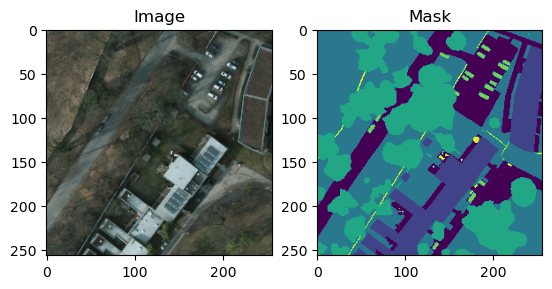

In [17]:
# observe sample from batch

fig, axs = plt.subplots(1, 2)

axs[0].imshow(inputs[0,:,:,:3])
axs[0].set_title('Image')

axs[1].imshow(label[0])
axs[1].set_title('Mask')

In [ ]:
# train model 
# Read this file for details on the training process

# !sbatch train.sh

In [74]:
# load in model history

with open('hist_1.json', 'r') as f:
    hist = json.load(f)

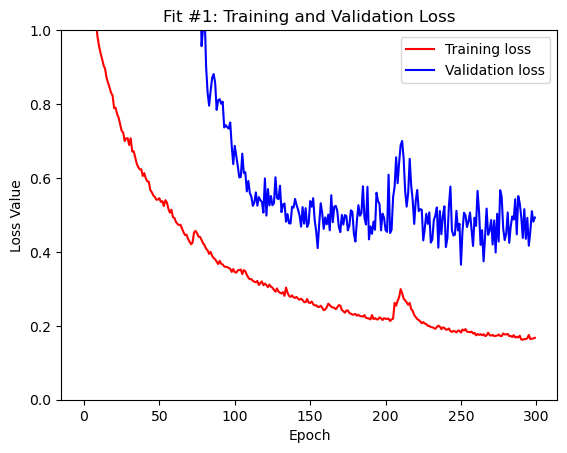

In [75]:
loss = hist['loss']
val_loss = hist['val_loss']

epochs = np.arange(0, 300, 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Fit #1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

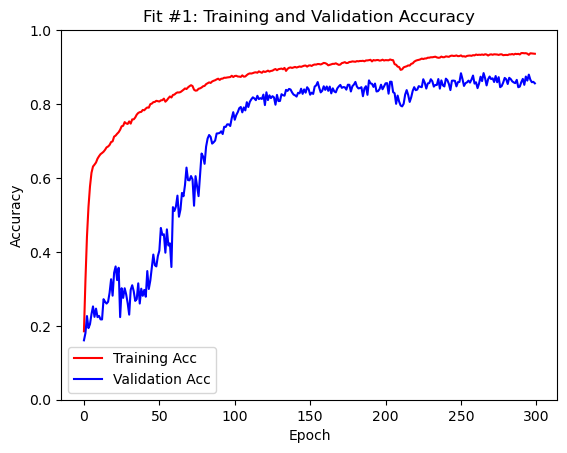

In [76]:
loss = hist['sparse_categorical_accuracy']
val_loss = hist['val_sparse_categorical_accuracy']

epochs = np.arange(0, 300, 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Acc')
plt.plot(epochs, val_loss, 'b', label='Validation Acc')
plt.title('Fit #1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [100]:
#defining Conv2d block for u-net
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, 
                               kernel_size = (kernelSize, kernelSize), 
                               kernel_initializer = 'he_normal', 
                               padding = 'same') (inputTensor)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, 
                               kernel_size = (kernelSize, kernelSize), 
                               kernel_initializer = 'he_normal', 
                               padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Now defining Unet 
def GiveMeUnet(inputImage, output_classes, numFilters = 16, dropouts = 0.1, doBatchNorm = True):
  
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(output_classes, (1, 1))(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [101]:
# init model object

output_classes = 6
img_width = 256
img_height = 256
channels = 4
inputs = tf.keras.layers.Input((img_width, img_height, channels)) 
unet = GiveMeUnet(inputs, output_classes, dropouts= 0.07)

In [102]:
# load model

unet.load_weights('./unet_1.h5')

In [103]:
# define functions to display model results
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0][:,:,:3], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image[:,:,:3], sample_mask, create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 420ms/step


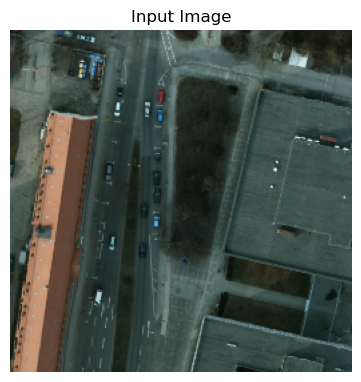

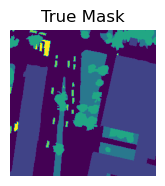

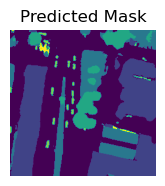

1/1 [==============================] - 0s 193ms/step


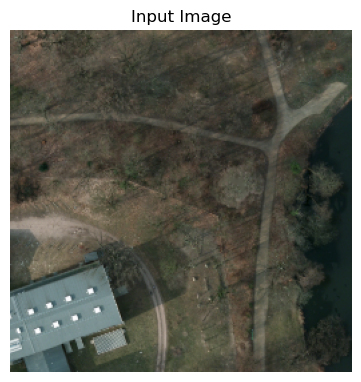

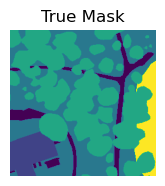

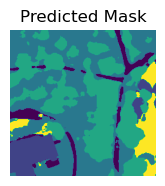

In [91]:
# dipslay model results

show_predictions(val_batches, 2)

In [104]:
# compile model to perform evaluation

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            )

In [83]:
# create model to use with Jacaard

def argmax_layer(x):
    return tf.cast(
            tf.keras.backend.reshape(tf.keras.backend.argmax(x, axis=-1), (-1, 256, 256, 1)),
            tf.float16
            )

UnetPredictor = tf.keras.Sequential([
    unet,
    tf.keras.layers.Lambda(argmax_layer),
])

UnetPredictor.compile(optimizer='adam',
              metrics=[tf.keras.metrics.MeanIoU(6)]
            )

In [67]:
jac_train = UnetPredictor.evaluate(train_batches)[1]
jac_val = UnetPredictor.evaluate(val_batches)[1]

print(f'Jacaard for Training: {jac_train}')
print(f'Jacaard for Validation: {jac_val}')

9/9 [==============================] - 2s 201ms/step - loss: 0.0000e+00 - mean_io_u_5: 0.6676
Jacaard for Training: 0.4472788870334625
Jacaard for Validation: 0.6676161885261536


In [ ]:
# creat confusion matrix for test scores

In [97]:
# get all labels
all_labels = []

for inputs, labels in test_batches.take(97):
    all_labels.append(labels)
    
all_labels = np.array(tf.reshape(tf.concat(all_labels, axis=0), (-1)))

In [95]:
preds = unet.predict(test_batches)
pred_classes = np.array(tf.reshape(tf.argmax(preds, axis=-1), (-1)))

13/13 [==============================] - 3s 176ms/step


In [106]:
# evaluate the models performance

test_acc = unet.evaluate(test_batches)[1]
test_jac = UnetPredictor.evaluate(test_batches)[1]

print(f'Test Accuracy: {test_acc}')
print(f'Test Jac: {test_jac}')

13/13 [==============================] - 3s 187ms/step - loss: 0.0000e+00 - mean_io_u_2: 0.6993
Test Accuracy: 0.860672652721405
Test Jac: 0.6993286609649658


In [ ]:
cm = confusion_matrix(all_labels, pred_classes)

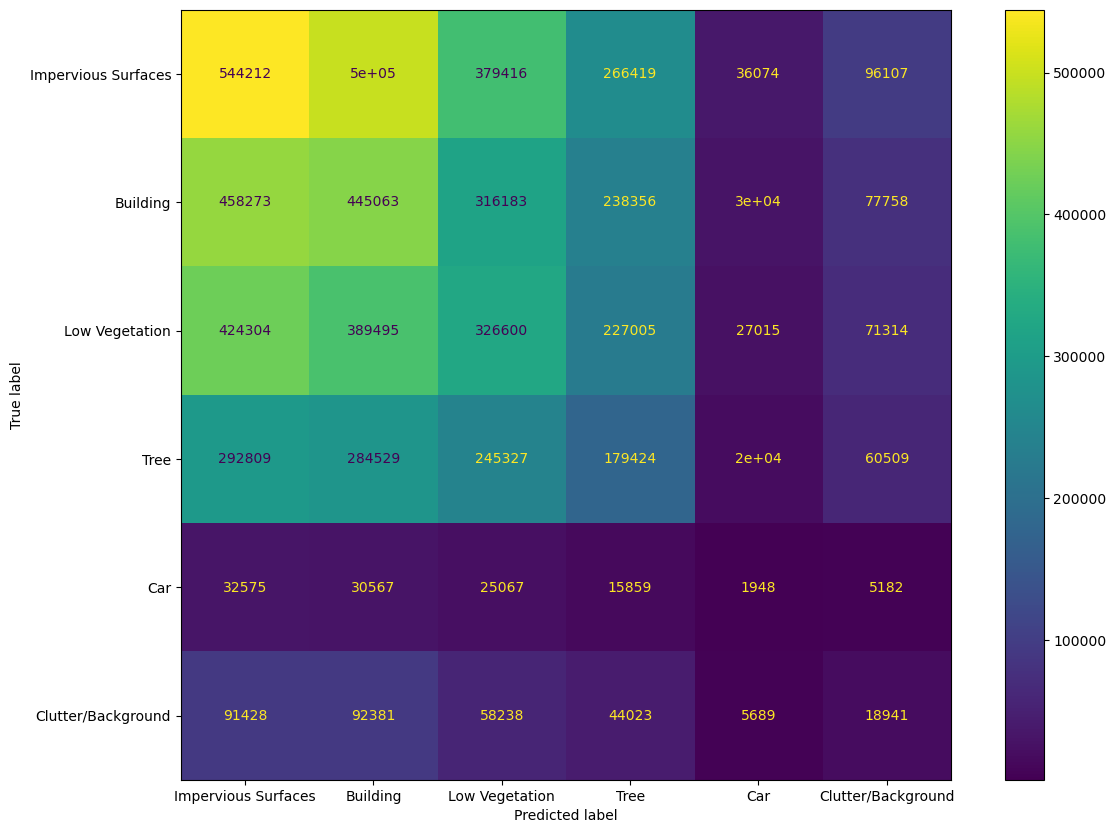

In [107]:
# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=name2int.keys())
fig, ax = plt.subplots(figsize=(14,10))
disp.plot(ax=ax)

plt.show()

1/1 [==============================] - 1s 522ms/step


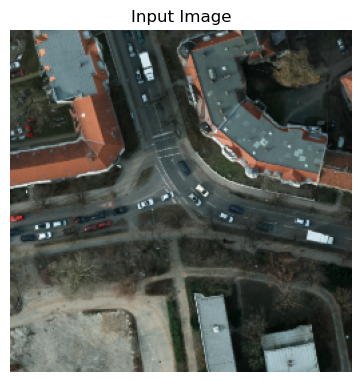

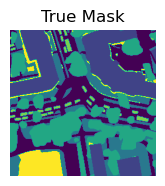

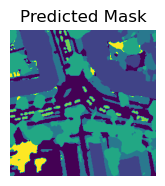

1/1 [==============================] - 0s 197ms/step


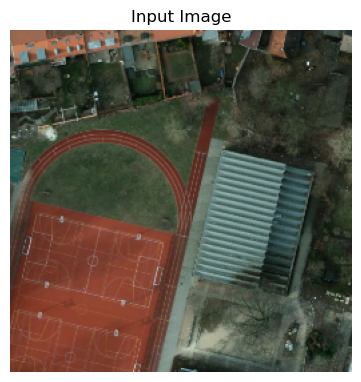

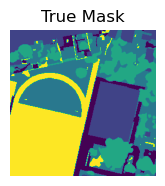

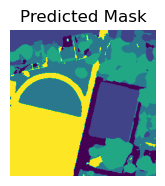

In [108]:
# display model results on test data

show_predictions(test_batches, 2)

## Step 2

--- 

The following adjustments to the training process were made:

- Class reweighting 
- Augment the images contrast value

In [56]:
# train model (uncomment the line below to run)
# view this file for details on the training process

#!sbatch train2.sh

Submitted batch job 110594


In [57]:
# load in model history

with open('hist_2.json', 'r') as f:
    hist = json.load(f)

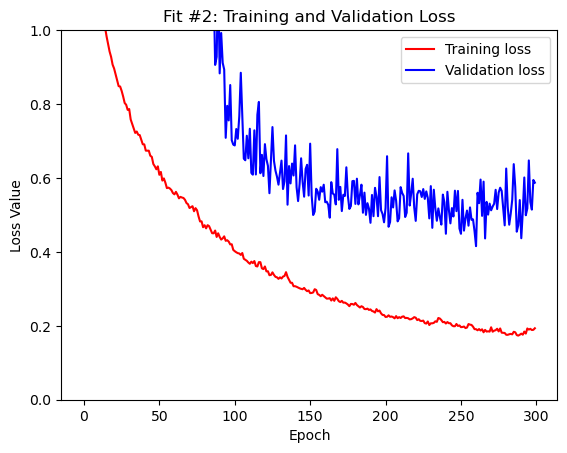

In [58]:
loss = hist['loss']
val_loss = hist['val_loss']

epochs = np.arange(0, 300, 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Fit #2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

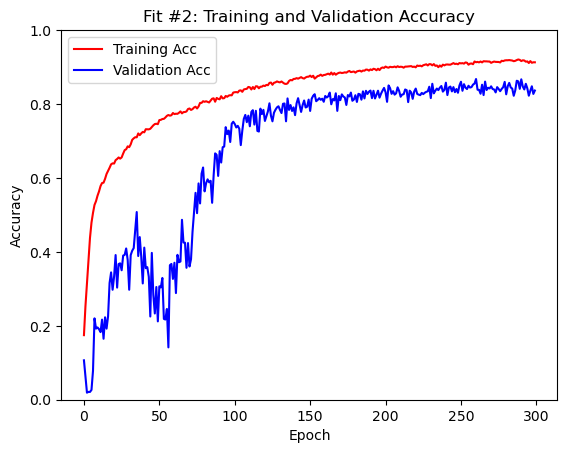

In [59]:
loss = hist['sparse_categorical_accuracy']
val_loss = hist['val_sparse_categorical_accuracy']

epochs = np.arange(0, 300, 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Acc')
plt.plot(epochs, val_loss, 'b', label='Validation Acc')
plt.title('Fit #2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [60]:
#defining Conv2d block for u-net
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, 
                               kernel_size = (kernelSize, kernelSize), 
                               kernel_initializer = 'he_normal', 
                               padding = 'same') (inputTensor)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
    
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, 
                               kernel_size = (kernelSize, kernelSize), 
                               kernel_initializer = 'he_normal', 
                               padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Now defining Unet 
def GiveMeUnet(inputImage, output_classes, numFilters = 16, dropouts = 0.1, doBatchNorm = True):
  
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(output_classes, (1, 1))(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [61]:
# init model object

output_classes = 6
img_width = 256
img_height = 256
channels = 4
inputs = tf.keras.layers.Input((img_width, img_height, channels)) 
unet = GiveMeUnet(inputs, output_classes, dropouts= 0.07)

In [63]:
# load model

unet.load_weights('./unet_2.h5')

1/1 [==============================] - 1s 503ms/step


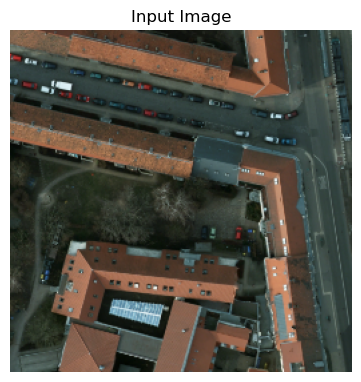

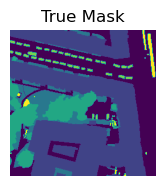

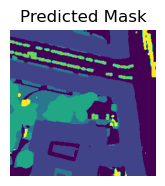

1/1 [==============================] - 0s 201ms/step


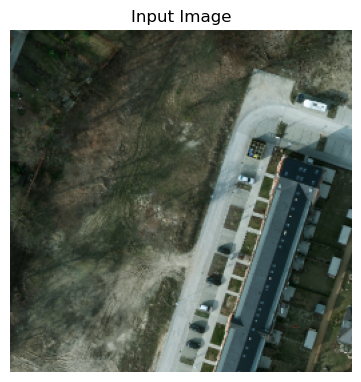

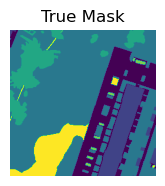

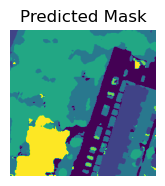

In [65]:
# display model results

show_predictions(val_batches, 2)

In [66]:
# compile model to perform evaluation

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            )

# create model to use with Jacaard
UnetPredictor = tf.keras.Sequential([
    unet,
    tf.keras.layers.Lambda(argmax_layer),
])

UnetPredictor.compile(optimizer='adam',
              metrics=[tf.keras.metrics.MeanIoU(6)]
            )

In [67]:
jac_train = UnetPredictor.evaluate(train_batches)[1]
jac_val = UnetPredictor.evaluate(val_batches)[1]

print(f'Jacaard for Training: {jac_train}')
print(f'Jacaard for Validation: {jac_val}')

9/9 [==============================] - 2s 193ms/step - loss: 0.0000e+00 - mean_io_u_1: 0.6660
Jacaard for Training: 0.8172027468681335
Jacaard for Validation: 0.6659846305847168


In [ ]:
# creat confusion matrix for test scores

In [68]:
# get all labels
all_labels = []

for inputs, labels in test_batches.take(97):
    all_labels.append(labels)
    
all_labels = np.array(tf.reshape(tf.concat(all_labels, axis=0), (-1)))

In [69]:
preds = unet.predict(test_batches)
pred_classes = np.array(tf.reshape(tf.argmax(preds, axis=-1), (-1)))

13/13 [==============================] - 3s 167ms/step


In [70]:
# evaluate the models performance

test_acc = unet.evaluate(test_batches)[1]
test_jac = UnetPredictor.evaluate(test_batches)[1]


print(f'Test Accuracy: {test_acc}')
print(f'Test Jac: {test_jac}')

13/13 [==============================] - 3s 184ms/step - loss: 0.0000e+00 - mean_io_u_1: 0.6486
Test Accuracy: 0.8485968112945557
Test Jac: 0.648642361164093


In [71]:
cm = confusion_matrix(all_labels, pred_classes)

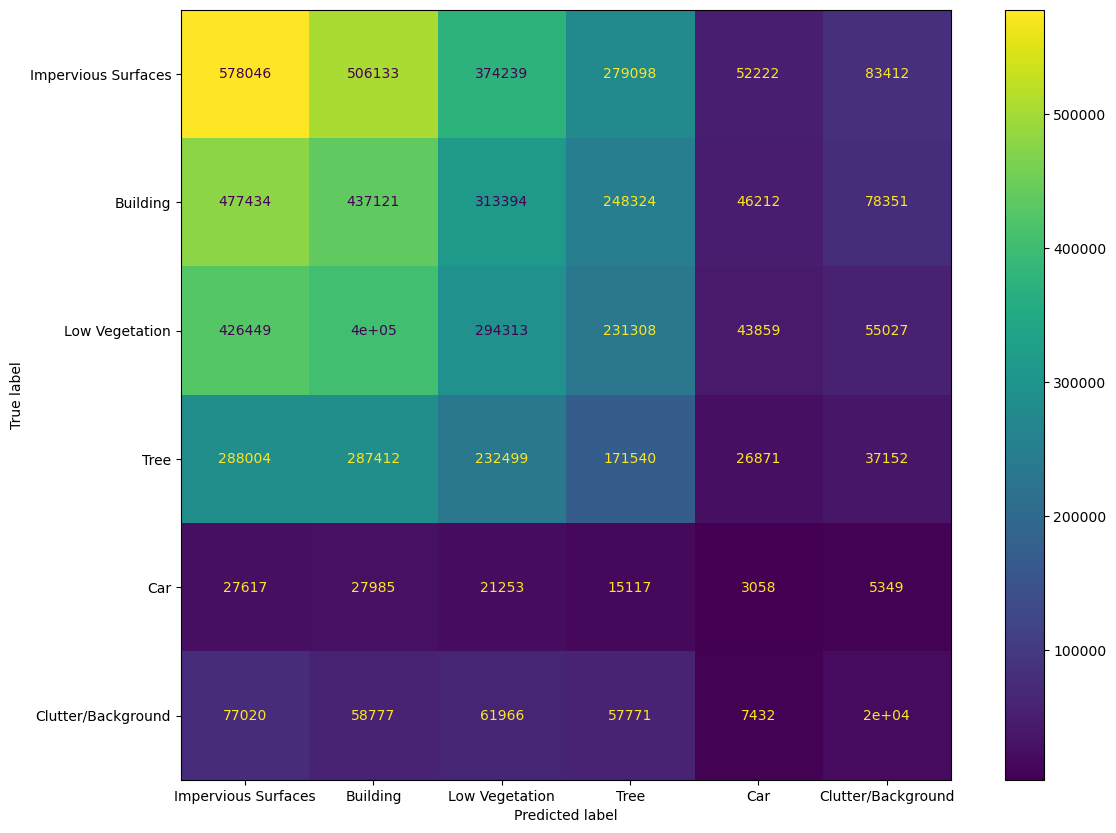

In [72]:
# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=name2int.keys())
fig, ax = plt.subplots(figsize=(14,10))
disp.plot(ax=ax)

plt.show()

1/1 [==============================] - 0s 307ms/step


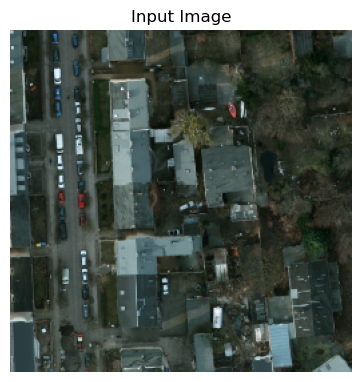

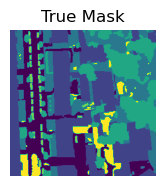

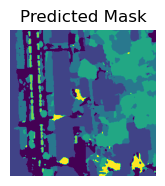

1/1 [==============================] - 0s 194ms/step


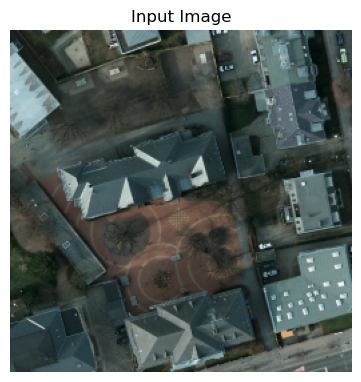

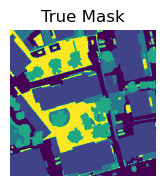

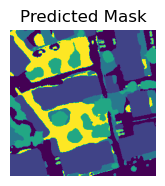

In [108]:
# display model results on test data

show_predictions(test_batches, 2)

## Report


**Constant Parameters**
- Random Seed: 12535235 
- Split: (159, 68, 97)
- Dropout: 0.07
- Random Horizontal Flip (w/seed)
- Images scaled between 0 & 1
- etc.

**Additions to Fit \#2**
- Random Contrast factor of 0.2 (w/seed)
- Class Reweighting via Inverse Class Freq. method

**Results**
- Fit /#1
    - Train Acc: 0.9360
    - Train Jac: 0.4472
    - Val Acc: 0.8560
    - Val Jac: 0.6676
    - Test Acc: 0.8606
    - Test Jac: 0.6993
- Fit /#2
    - Train Acc: 0.9129
    - Train Jac: 0.8172
    - Val Acc: 0.8365
    - Val Jac: 0.6660
    - Test Acc: 0.8486
    - Test Jac: 0.6486

- Interpretation:
    - The adjustments made for the Fit 2 lowered model performance, but arguably, but the lower train accuracy suggests that additional epochs have helper the overall socres.
    - Notably, the Train Jacaard score was much higher for the Fit 2. This suggests that the model performed well on the minority classes during the training of Fit 2, which is to be expected.
    
- Resources: 
    - Tensorflow/Keras Docs
    - https://www.tensorflow.org/tutorials/images/segmentation
    